### Loading Libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn import tree

### Loading and Cleaning Data

In [3]:
df = pd.read_csv('../Data/clean_data.csv')
df = df.dropna(axis=0)
df = df.drop(columns=['Unnamed: 0','level_0','index'], axis=1)
df.describe()

,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,ta_to_channel,no_deposit,refundable_deposit,nonrefundable_deposit,with_company,is_contract,is_group,is_transient,is_transient_party,stay_length
count,72514.000000,72514.000000,72514.000000,72514.000000,72514.000000,72514.000000,72514.000000,72514.000000,72514.000000,72514.000000,...,72514.000000,72514.000000,72514.000000,72514.0,72514.000000,72514.000000,72514.000000,72514.000000,72514.000000,72514.000000
mean,81.028105,6.521748,27.058375,15.833039,0.939336,2.485037,1.839824,0.103677,0.010205,0.037538,...,0.775643,0.996980,0.001738,0.0,0.071338,0.038268,0.006881,0.711063,0.243787,3.421932
std,91.384938,3.127892,13.793632,8.776169,0.986946,1.897016,0.502700,0.393228,0.112666,0.190076,...,0.417161,0.054873,0.041649,0.0,0.257390,0.191845,0.082669,0.453272,0.429369,2.533769
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,4.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,47.000000,7.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000
75%,126.000000,9.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000
max,709.000000,12.000000,53.000000,31.000000,19.000000,50.000000,4.000000,3.000000,10.000000,1.000000,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,69.000000


### Functions

In [13]:
def make_dataset(df, features, test_size=.3, normalize = True, binned= False):
    X = df.loc[:,features].values
    if normalize:
        X = StandardScaler().fit_transform(X)
    if binned:
        y = df['adr'].values
        bin_edges = np.linspace(np.min(y), np.max(y), 20)
        y_bin = np.zeros(np.shape(y))
        for i in range(len(y)):
            for j in range(len(bin_edges)):
                if y[i] < bin_edges[j]:
                    y_bin[i] = j
                    break
        y = y_bin
    else:
        y = df['adr'].values
        
    assert(len(X) == len(y))
    
    print("Total Size of data: ", len(X))
    
    test_size = int(len(X)*test_size)
    ind = [np.random.choice(range(len(X)), size=test_size, replace=False)]
    X_test = X[ind]
    y_test = y[ind]
    X_train = np.delete(X, ind, axis=0)
    y_train = np.delete(y, ind)
    
    print("Feature", features)
    print("X_train: ", np.shape(X_train))
    print("y_train: ", np.shape(y_train))
    print("X_test: ", np.shape(X_test))
    print("y_test: ", np.shape(y_test))
    
    return X_train, y_train, X_test, y_test

def calc_rmse(y_hat, y):
    return np.sqrt(np.mean((y_hat-y)**2))

def lin_reg(X_train, y_train, X_test, y_test):
    reg = LinearRegression().fit(X_train, y_train)
    y_hat = reg.predict(X_test)
    score = reg.score(X_test, y_test)
    root_mse = calc_rmse(y_hat, y_test)
    print("score: ", score)
    print("Root Mean Square Error: ", root_mse)
    
    return y_hat, score, root_mse

def plot_err_hist(y_hat, y, rmse):
    plt.hist(np.abs(y_hat - y))
    title = "Error Histogram: RMSE = " + str(np.round(rmse,2))
    plt.title(title)
    plt.xlabel("Error Bins")
    plt.ylabel("Frequency")
    plt.show()
    
def plot_y(y_hat, y):
    x = range(len(y_hat))
    plt.scatter(x,np.sort(y), alpha=.25, label="y")
    plt.scatter(x,np.sort(y_hat), alpha=.25, label="y_hat")
    plt.legend()
    plt.xlabel("Indicies")
    plt.ylabel("Average Daily Rate")
    plt.title("Predicted and Average Daily Rate")
    plt.show()
    
def make_PCA(X_train, X_test, features, thresh = .90):
    pca = PCA(thresh)
    pca.fit(X_train)
    
    var = pca.explained_variance_ratio_
    print("number components: ", len(var))
    evar = np.sum(var)
    print("Explained Variance:", evar)
    
    X_pcs_train = pca.transform(X_train)
    X_pcs_test = pca.transform(X_test)
    
    n_pcs= pca.components_.shape[0]
    most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

    initial_feature_names = features
    most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
    dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
    
    return X_pcs_train, X_pcs_test, dic

def log_reg(X_train, y_train, X_test, y_test):
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    y_hat = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    rmse = calc_rmse(y_hat, y_test)
    print("score: ", score)
    print("Root Mean Square Error: ", rmse)
    return y_hat, score, rmse

def tree_class(X_train, y_train, X_test, y_test, verbose=False):
    X_train, y_train, X_test, y_test = make_dataset(df, features, binned=True)
    decision_tree = DecisionTreeClassifier(random_state=0)
    decision_tree = decision_tree.fit(X_train, y_train)
    y_hat = decision_tree.predict(X_test)
    r = export_text(decision_tree, feature_names=features)
    if verbose:
        print(r)
    rmse = calc_rmse(y_hat, y_test)
    return y_hat, rmse
    

def tree_reg(X_train,y_train, X_test, y_test):
    clf = tree.DecisionTreeRegressor()
    clf = clf.fit(X_train, y_train)
    y_hat = clf.predict(X_test)
    rmse = np.sqrt(np.mean((y_hat-y_test)**2))
    print("Root Mean Square Error: ", rmse)
    return y_hat, rmse

### Loading All Features

In [4]:
features = list(df.columns)
features.remove('adr')
# features

### Linear Regression, No PCA

Total Size of data:  43341
Feature ['lead_time', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests', 'is_resort', 'bought_meal', 'aviation_segment', 'corporate_segment', 'groups_segment', 'offline_ta_to_segment', 'online_ta_segment', 'corporate_channel', 'direct_channel', 'gds_channel', 'ta_to_channel', 'no_deposit', 'refundable_deposit', 'nonrefundable_deposit', 'with_company', 'is_contract', 'is_group', 'is_transient', 'is_transient_party', 'stay_length']
X_train:  (30339, 35)
y_train:  (30339,)
X_test:  (13002, 35)
y_test:  (13002,)


/tmp/ipykernel_362/1325416259.py:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_test = X[ind]
/tmp/ipykernel_362/1325416259.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_test = y[ind]


score:  0.29649698777972355
Root Mean Square Error:  42.26092619240268


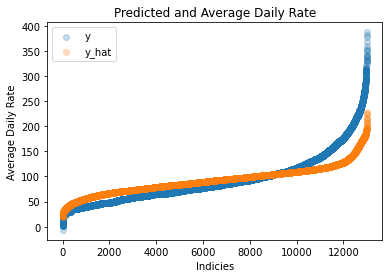

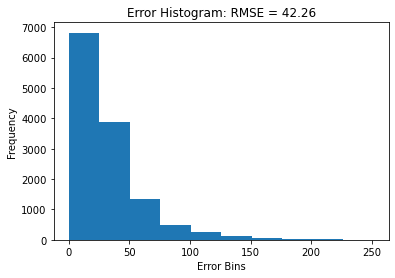

In [5]:
X_train, y_train, X_test, y_test = make_dataset(df, features, binned=False)
y_hat, score, rmse = lin_reg(X_train, y_train, X_test, y_test)
plot_y(y_hat, y_test)
plot_err_hist(y_hat, y_test, rmse)

### Linear Regression, With PCA

Total Size of data:  43341
Feature ['lead_time', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests', 'is_resort', 'bought_meal', 'aviation_segment', 'corporate_segment', 'groups_segment', 'offline_ta_to_segment', 'online_ta_segment', 'corporate_channel', 'direct_channel', 'gds_channel', 'ta_to_channel', 'no_deposit', 'refundable_deposit', 'nonrefundable_deposit', 'with_company', 'is_contract', 'is_group', 'is_transient', 'is_transient_party', 'stay_length']
X_train:  (30339, 35)
y_train:  (30339,)
X_test:  (13002, 35)
y_test:  (13002,)


/tmp/ipykernel_362/1325416259.py:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_test = X[ind]
/tmp/ipykernel_362/1325416259.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_test = y[ind]


number components:  24
Explained Variance: 0.9574253053419146
score:  0.28232086502510334
Root Mean Square Error:  42.99269668268692


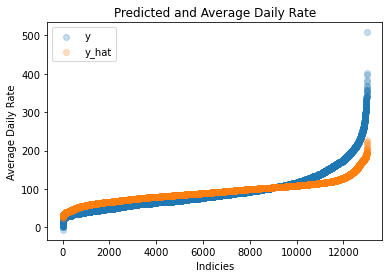

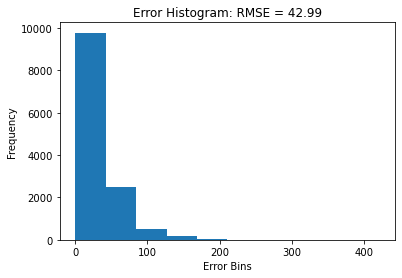

In [6]:
X_train, y_train, X_test, y_test = make_dataset(df, features, binned=False)
X_train_pca, X_test_pca, col_dic = make_PCA(X_train, X_test, features, thresh=.95)
y_hat, score, rmse = lin_reg(X_train_pca, y_train, X_test_pca, y_test)
plot_y(y_hat, y_test)
plot_err_hist(y_hat, y_test, rmse)

### Logistic Regression, With PCA

Total Size of data:  43341
Feature ['lead_time', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests', 'is_resort', 'bought_meal', 'aviation_segment', 'corporate_segment', 'groups_segment', 'offline_ta_to_segment', 'online_ta_segment', 'corporate_channel', 'direct_channel', 'gds_channel', 'ta_to_channel', 'no_deposit', 'refundable_deposit', 'nonrefundable_deposit', 'with_company', 'is_contract', 'is_group', 'is_transient', 'is_transient_party', 'stay_length']
X_train:  (30339, 35)
y_train:  (30339,)
X_test:  (13002, 35)
y_test:  (13002,)


/tmp/ipykernel_362/1325416259.py:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_test = X[ind]
/tmp/ipykernel_362/1325416259.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_test = y[ind]
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the d

score:  0.39532379633902476
Root Mean Square Error:  1.8376039253421441


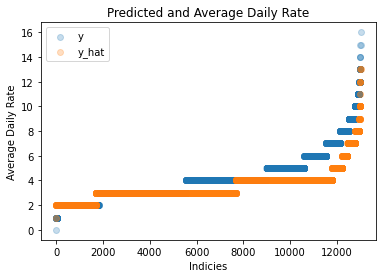

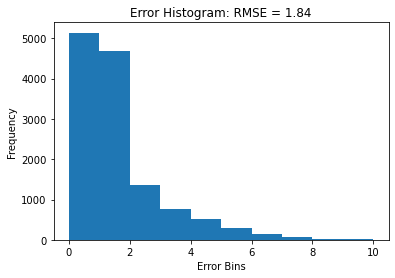

In [7]:
X_train, y_train, X_test, y_test = make_dataset(df, features, binned=True)
y_hat, score, rmse = log_reg(X_train, y_train, X_test, y_test)
plot_y(y_hat, y_test)
plot_err_hist(y_hat, y_test, rmse)

### Logistic Regression, With PCA

Total Size of data:  43341
Feature ['lead_time', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests', 'is_resort', 'bought_meal', 'aviation_segment', 'corporate_segment', 'groups_segment', 'offline_ta_to_segment', 'online_ta_segment', 'corporate_channel', 'direct_channel', 'gds_channel', 'ta_to_channel', 'no_deposit', 'refundable_deposit', 'nonrefundable_deposit', 'with_company', 'is_contract', 'is_group', 'is_transient', 'is_transient_party', 'stay_length']
X_train:  (30339, 35)
y_train:  (30339,)
X_test:  (13002, 35)
y_test:  (13002,)


/tmp/ipykernel_362/1325416259.py:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_test = X[ind]
/tmp/ipykernel_362/1325416259.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_test = y[ind]


number components:  24
Explained Variance: 0.955875698208612


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


score:  0.4053222581141363
Root Mean Square Error:  1.8576680613224552


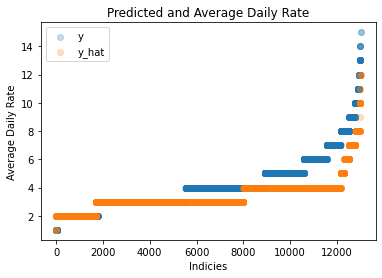

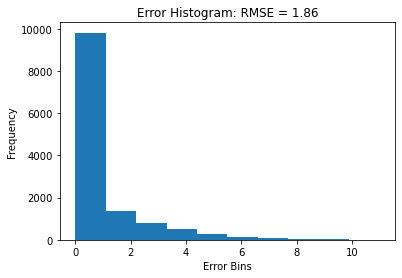

In [8]:
X_train, y_train, X_test, y_test = make_dataset(df, features, binned=True)
X_train_pca, X_test_pca, col_dic = make_PCA(X_train, X_test, features, thresh=.95)
y_hat, score, rmse = log_reg(X_train_pca, y_train, X_test_pca, y_test)
plot_y(y_hat, y_test)
plot_err_hist(y_hat, y_test, rmse)

### Decision Tree Classification, No PCA

Total Size of data:  43341
Feature ['lead_time', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests', 'is_resort', 'bought_meal', 'aviation_segment', 'corporate_segment', 'groups_segment', 'offline_ta_to_segment', 'online_ta_segment', 'corporate_channel', 'direct_channel', 'gds_channel', 'ta_to_channel', 'no_deposit', 'refundable_deposit', 'nonrefundable_deposit', 'with_company', 'is_contract', 'is_group', 'is_transient', 'is_transient_party', 'stay_length']
X_train:  (30339, 35)
y_train:  (30339,)
X_test:  (13002, 35)
y_test:  (13002,)
Total Size of data:  43341
Feature ['lead_time', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults',

/tmp/ipykernel_362/1325416259.py:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_test = X[ind]
/tmp/ipykernel_362/1325416259.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_test = y[ind]
/tmp/ipykernel_362/1325416259.py:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_test = X[ind]
/tmp/ipykernel_362/

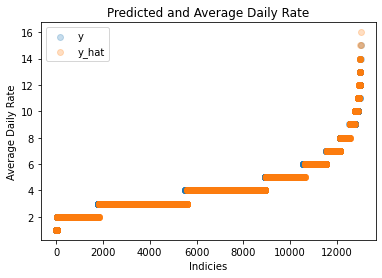

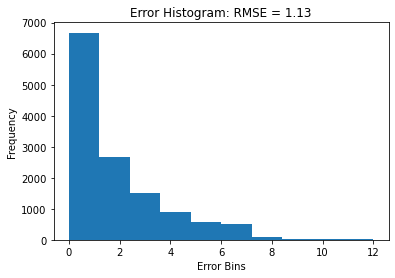

In [9]:
X_train, y_train, X_test, y_test = make_dataset(df, features, binned=True)
y_hat, rmse = tree_class(X_train, y_train, X_test, y_test)
plot_y(y_hat, y_test)
plot_err_hist(y_hat, y_test, rmse)

### Decision Tree Classification, With PCA

Total Size of data:  43341
Feature ['lead_time', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests', 'is_resort', 'bought_meal', 'aviation_segment', 'corporate_segment', 'groups_segment', 'offline_ta_to_segment', 'online_ta_segment', 'corporate_channel', 'direct_channel', 'gds_channel', 'ta_to_channel', 'no_deposit', 'refundable_deposit', 'nonrefundable_deposit', 'with_company', 'is_contract', 'is_group', 'is_transient', 'is_transient_party', 'stay_length']
X_train:  (30339, 35)
y_train:  (30339,)
X_test:  (13002, 35)
y_test:  (13002,)


/tmp/ipykernel_362/1572250069.py:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_test = X[ind]
/tmp/ipykernel_362/1572250069.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_test = y[ind]


number components:  24
Explained Variance: 0.9563935889408014
Total Size of data:  43341
Feature ['lead_time', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests', 'is_resort', 'bought_meal', 'aviation_segment', 'corporate_segment', 'groups_segment', 'offline_ta_to_segment', 'online_ta_segment', 'corporate_channel', 'direct_channel', 'gds_channel', 'ta_to_channel', 'no_deposit', 'refundable_deposit', 'nonrefundable_deposit', 'with_company', 'is_contract', 'is_group', 'is_transient', 'is_transient_party', 'stay_length']
X_train:  (30339, 35)
y_train:  (30339,)
X_test:  (13002, 35)
y_test:  (13002,)


/tmp/ipykernel_362/1572250069.py:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_test = X[ind]
/tmp/ipykernel_362/1572250069.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_test = y[ind]


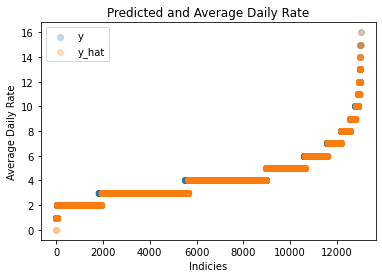

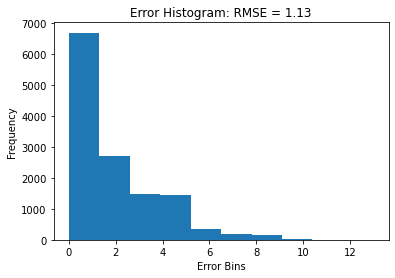

{'PC0': 'corporate_segment', 'PC1': 'is_transient', 'PC2': 'stay_length', 'PC3': 'direct_channel', 'PC4': 'arrival_date_week_number', 'PC5': 'no_deposit', 'PC6': 'offline_ta_to_segment', 'PC7': 'previous_cancellations', 'PC8': 'bought_meal', 'PC9': 'babies', 'PC10': 'is_contract', 'PC11': 'aviation_segment', 'PC12': 'is_group', 'PC13': 'arrival_date_day_of_month', 'PC14': 'children', 'PC15': 'children', 'PC16': 'required_car_parking_spaces', 'PC17': 'booking_changes', 'PC18': 'adults', 'PC19': 'lead_time', 'PC20': 'total_of_special_requests', 'PC21': 'is_repeated_guest', 'PC22': 'lead_time', 'PC23': 'groups_segment'}


In [16]:
X_train, y_train, X_test, y_test = make_dataset(df, features, binned=True)
X_train_pca, X_test_pca, col_dict = make_PCA(X_train, X_test, features, thresh=.95)
y_hat, rmse = tree_class(X_train_pca, y_train, X_test_pca, y_test, verbose=True)
plot_y(y_hat, y_test)
plot_err_hist(y_hat, y_test, rmse)
print(col_dict)

### Decision Tree Regression, No PCA

Total Size of data:  43341
Feature ['lead_time', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests', 'is_resort', 'bought_meal', 'aviation_segment', 'corporate_segment', 'groups_segment', 'offline_ta_to_segment', 'online_ta_segment', 'corporate_channel', 'direct_channel', 'gds_channel', 'ta_to_channel', 'no_deposit', 'refundable_deposit', 'nonrefundable_deposit', 'with_company', 'is_contract', 'is_group', 'is_transient', 'is_transient_party', 'stay_length']
X_train:  (30339, 35)
y_train:  (30339,)
X_test:  (13002, 35)
y_test:  (13002,)


/tmp/ipykernel_362/1325416259.py:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_test = X[ind]
/tmp/ipykernel_362/1325416259.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_test = y[ind]


Root Mean Square Error:  29.084903227035856


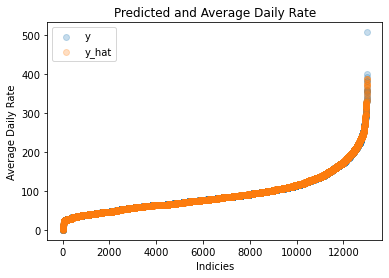

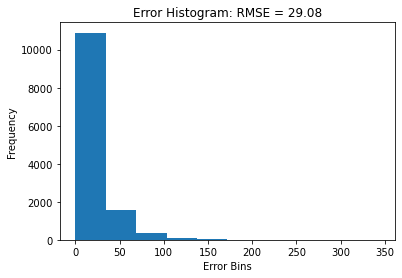

In [11]:
X_train, y_train, X_test, y_test = make_dataset(df, features, binned=False)
y_hat, rmse = tree_reg(X_train, y_train, X_test, y_test)
plot_y(y_hat, y_test)
plot_err_hist(y_hat, y_test, rmse)

### Decision Tree Regression, With PCA

Total Size of data:  43341
Feature ['lead_time', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests', 'is_resort', 'bought_meal', 'aviation_segment', 'corporate_segment', 'groups_segment', 'offline_ta_to_segment', 'online_ta_segment', 'corporate_channel', 'direct_channel', 'gds_channel', 'ta_to_channel', 'no_deposit', 'refundable_deposit', 'nonrefundable_deposit', 'with_company', 'is_contract', 'is_group', 'is_transient', 'is_transient_party', 'stay_length']
X_train:  (30339, 35)
y_train:  (30339,)
X_test:  (13002, 35)
y_test:  (13002,)


/tmp/ipykernel_362/1325416259.py:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_test = X[ind]
/tmp/ipykernel_362/1325416259.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_test = y[ind]


number components:  24
Explained Variance: 0.9572419489459099
Root Mean Square Error:  35.526625960503125


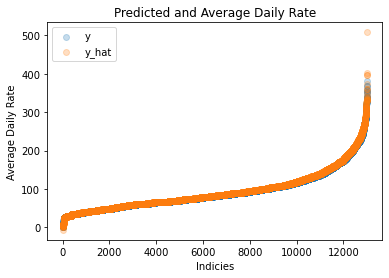

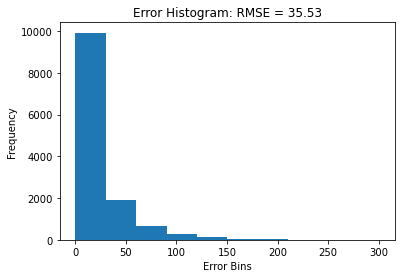

In [12]:
X_train, y_train, X_test, y_test = make_dataset(df, features, binned=False)
X_train_pca, X_test_pca, col_dic = make_PCA(X_train, X_test, features, thresh=.95)
y_hat, rmse = tree_reg(X_train_pca, y_train, X_test_pca, y_test)
plot_y(y_hat, y_test)
plot_err_hist(y_hat, y_test, rmse)